In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [4]:
test_data_path = 'test_air_quality_data.parquet'

In [5]:
class ClassicalLSTMModel(nn.Module):
    """LSTM model for multi-step time-series forecasting"""
    def __init__(self, n_features, n_lstm_units=128, num_layers=4, output_len=72):
        super(ClassicalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.classifier = nn.Linear(n_lstm_units, output_len)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_lstm_output = lstm_out[:, -1, :]
        output = self.classifier(final_lstm_output)
        return torch.sigmoid(output)

In [6]:
def transform_data(file_path, lat_bins, lon_bins, le_location):
    """Transform raw test data using saved preprocessing objects"""
    df = pd.read_parquet(file_path)
    
    # Use provided bins from training data
    lat_positions = pd.cut(df['lat'], bins=lat_bins, labels=False, include_lowest=True)
    lon_positions = pd.cut(df['lon'], bins=lon_bins, labels=False, include_lowest=True)
    df['location'] = lat_positions * 20 + lon_positions
    df['location'] = df['location'].fillna(0).astype(int)
    
    # Process class and time features
    df['class'] = df['class'].isin(['Good', 'Moderate']).astype(int)
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    
    # Select columns
    list_of_columns = ['class', 'PM25_MERRA2', 'DUCMASS', 'TOTANGSTR', 'DUFLUXV', 'SSFLUXV', 'DUFLUXU', 'BCCMASS', 'SSSMASS25', 'location']
    selected_columns = list_of_columns + ['year', 'month', 'day', 'hour']
    df = df[selected_columns]
    
    # Encode location using saved encoder
    df['location_encoded'] = df['location'].map(
        lambda x: le_location.transform([x])[0] if x in le_location.classes_ else -1
    )
    
    df = df.sort_values(['location_encoded', 'year', 'month', 'day', 'hour'])
    
    # Define feature columns
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'year', 'month', 'day', 'hour', 'location_encoded'
    ]]
    df.drop(columns='location', inplace=True)
    feature_columns.append('location_encoded')
    
    return df, feature_columns

In [7]:
def create_sequences_memory_efficient(df, feature_columns, scaler, 
                                    input_len=168, output_len=72, stride=24):
    """Create sequences for testing using saved scaler"""
    print(f"Creating sequences with input length={input_len}, output length={output_len}...")
    
    X_scaled = scaler.transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()

    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values

        max_start_idx = len(loc_df) - input_len - output_len

        for j in range(0, max_start_idx, stride):
            X_seq = loc_X.iloc[j : j + input_len].values
            y_target = loc_y[j + input_len : j + input_len + output_len]

            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)

        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)

    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Input sequence shape: {X_sequences.shape}")
    print(f"Output sequence shape: {y_sequences.shape}")

    return X_sequences, y_sequences, location_indices

In [8]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, 72 + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test, output_seq_len=72):
    """
    Evaluate the model with the needed metrics
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    preds_flat, labels_flat = all_preds.flatten(), all_labels.flatten()

    # All metrics Required
    accuracy = (preds_flat == labels_flat).mean()
    precision = precision_score(labels_flat, preds_flat, average="binary")
    recall = recall_score(labels_flat, preds_flat, average="binary")
    f1 = f1_score(labels_flat, preds_flat, average="binary")
    conf_matrix = confusion_matrix(labels_flat, preds_flat)

    # Per-location metrics
    unique_locations = np.unique(location_indices_test)
    location_metrics = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc, labels_loc = all_preds[idx].flatten(), all_labels[idx].flatten()
        location_metrics[int(loc)] = {
            "accuracy": (preds_loc == labels_loc).mean(),
            "precision": precision_score(labels_loc, preds_loc, average="binary"),
            "recall": recall_score(labels_loc, preds_loc, average="binary"),
            "f1": f1_score(labels_loc, preds_loc, average="binary"),
            "confusion_matrix": confusion_matrix(labels_loc, preds_loc)
        }

    # Per-hour metrics
    hour_metrics = []
    for hour in range(output_seq_len):
        preds_hour, labels_hour = all_preds[:, hour], all_labels[:, hour]
        hour_metrics.append({
            "hour": hour + 1,
            "accuracy": (preds_hour == labels_hour).mean(),
            "precision": precision_score(labels_hour, preds_hour, average="binary"),
            "recall": recall_score(labels_hour, preds_hour, average="binary"),
            "f1": f1_score(labels_hour, preds_hour, average="binary"),
            "confusion_matrix": confusion_matrix(labels_hour, preds_hour)
        })

    return {
        "overall": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": conf_matrix
        },
        "per_location": location_metrics,
        "per_hour": hour_metrics,
        "preds_flat": preds_flat,  
        "labels_flat": labels_flat  
    }

In [10]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [11]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [12]:
with open('preprocessing_state.pkl', 'rb') as f:
    preprocessing_state = pickle.load(f)

In [13]:
lat_bins = preprocessing_state['lat_bins']
lon_bins = preprocessing_state['lon_bins']
le_location = preprocessing_state['le_location']
feature_columns = preprocessing_state['feature_columns']
scaler = joblib.load('scaler.pkl')

df, feature_columns = transform_data(test_data_path, lat_bins, lon_bins, le_location)

X_test, y_test, location_indices = create_sequences_memory_efficient(
    df, feature_columns, scaler, input_len=168, output_len=72, stride=24
)

Creating sequences with input length=168, output length=72...
Processed location 100/400
Processed location 200/400
Processed location 300/400
Processed location 400/400
Total sequences: 79340
Input sequence shape: (79340, 168, 9)
Output sequence shape: (79340, 72)


In [14]:
batch_size = 512
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
n_lstm_units = 128
num_layers = 4
model = ClassicalLSTMModel(
    n_features=len(feature_columns),
    n_lstm_units=n_lstm_units,
    num_layers=num_layers,
    output_len=72
)

model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
print("\nClassical LSTM Model Architecture:")
print(model)

# Evaluate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=72, bias=True)
)


/tmp/ipykernel_5718/926262218.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


ClassicalLSTMModel(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=72, bias=True)
)

In [17]:
print("\nCalculating detailed accuracy metrics...")
metrics = evaluate_model_per_location_and_hour(
    model, test_loader, device, location_indices
)

# Extract the specific metrics we need
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]


Calculating detailed accuracy metrics...



Per-location accuracy (averaged over all 72 hours):
Location 0: 0.9209
Location 1: 0.9339
Location 2: 0.9278
Location 3: 0.9040
Location 4: 0.9217
Location 5: 0.9374
Location 6: 0.9431
Location 7: 0.9498
Location 8: 0.9597
Location 9: 0.9685
Location 10: 0.9698
Location 11: 0.9520
Location 12: 0.9461
Location 13: 0.8630
Location 14: 0.9278
Location 15: 0.9152
Location 16: 0.8949
Location 17: 0.8733
Location 18: 0.8795
Location 19: 0.9138
Location 20: 0.9278
Location 21: 0.9442
Location 22: 0.9435
Location 23: 0.9155
Location 24: 0.9223
Location 25: 0.9385
Location 26: 0.9540
Location 27: 0.9544
Location 28: 0.9644
Location 29: 0.9719
Location 30: 0.9659
Location 31: 0.9592
Location 32: 0.9449
Location 33: 0.8557
Location 34: 0.9228
Location 35: 0.9209
Location 36: 0.9034
Location 37: 0.8961
Location 38: 0.9254
Location 39: 0.9227
Location 40: 0.9268
Location 41: 0.9458
Location 42: 0.9523
Location 43: 0.9243
Location 44: 0.9176
Location 45: 0.9350
Location 46: 0.9477
Location 47: 0.95

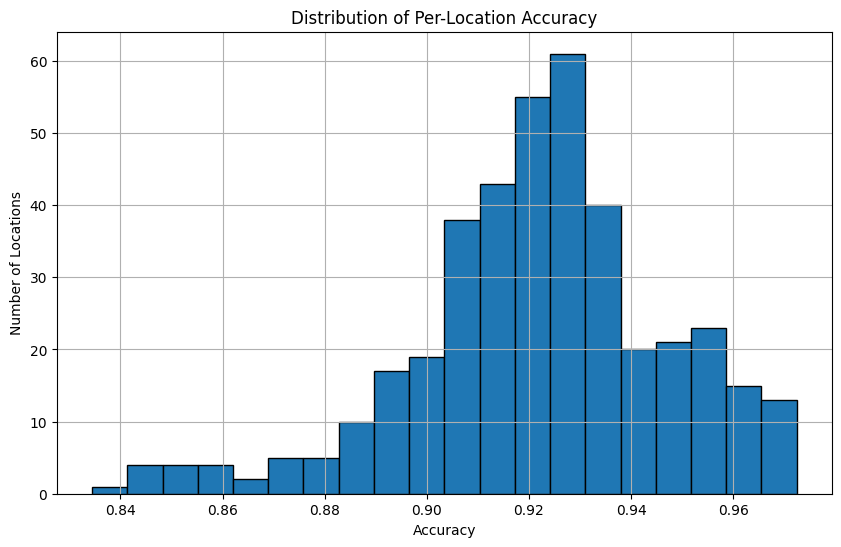

In [18]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_metrics.keys()):
    print(f"Location {loc}: {location_metrics[loc]['accuracy']:.4f}")

# Plot location accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist([loc_metrics['accuracy'] for loc_metrics in location_metrics.values()], bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Per-hour accuracy (averaged over all locations):
Hour 1: 0.9757
Hour 2: 0.9703
Hour 3: 0.9584
Hour 4: 0.9449
Hour 5: 0.9371
Hour 6: 0.9294
Hour 7: 0.9154
Hour 8: 0.9170
Hour 9: 0.9206
Hour 10: 0.9253
Hour 11: 0.9286
Hour 12: 0.9275
Hour 13: 0.9252
Hour 14: 0.9275
Hour 15: 0.9265
Hour 16: 0.9234
Hour 17: 0.9164
Hour 18: 0.9155
Hour 19: 0.9167
Hour 20: 0.9182
Hour 21: 0.9216
Hour 22: 0.9233
Hour 23: 0.9235
Hour 24: 0.9245
Hour 25: 0.9239
Hour 26: 0.9245
Hour 27: 0.9242
Hour 28: 0.9248
Hour 29: 0.9245
Hour 30: 0.9204
Hour 31: 0.9079
Hour 32: 0.9122
Hour 33: 0.9158
Hour 34: 0.9232
Hour 35: 0.9270
Hour 36: 0.9278
Hour 37: 0.9265
Hour 38: 0.9292
Hour 39: 0.9269
Hour 40: 0.9247
Hour 41: 0.9159
Hour 42: 0.9159
Hour 43: 0.9161
Hour 44: 0.9178
Hour 45: 0.9207
Hour 46: 0.9224
Hour 47: 0.9226
Hour 48: 0.9235
Hour 49: 0.9222
Hour 50: 0.9220
Hour 51: 0.9207
Hour 52: 0.9203
Hour 53: 0.9204
Hour 54: 0.9151
Hour 55: 0.9035
Hour 56: 0.9053
Hour 57: 0.9101
Hour 58: 0.9159
Hour 59: 0.9210
Hour 60: 0.9213

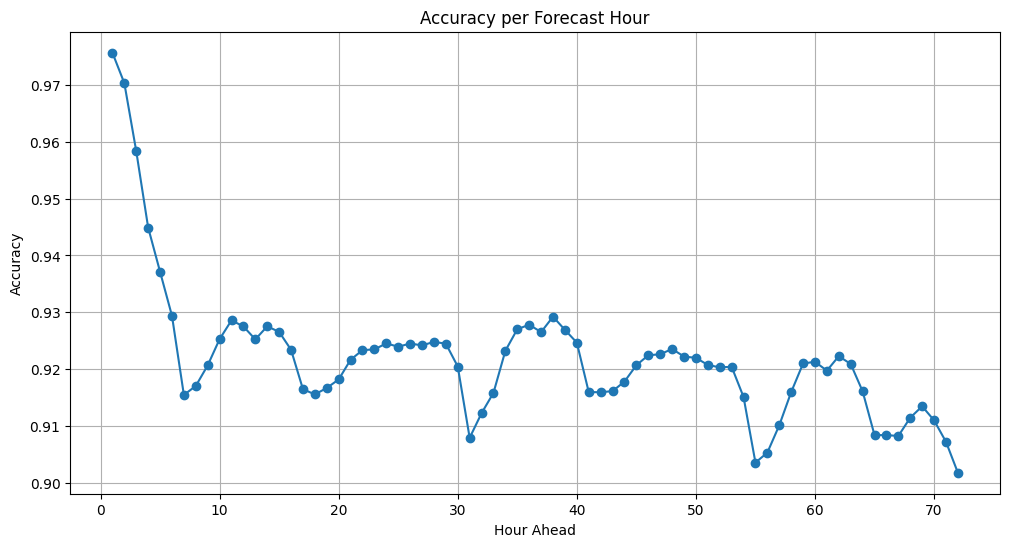

In [19]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour_metrics_dict in hour_metrics:
    hour = hour_metrics_dict["hour"]
    accuracy = hour_metrics_dict["accuracy"]
    print(f"Hour {hour}: {accuracy:.4f}")

# Plot hour accuracy
plt.figure(figsize=(12, 6))
plt.plot([hm["hour"] for hm in hour_metrics], [hm["accuracy"] for hm in hour_metrics], marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating detailed accuracy metrics...

Overall Confusion Matrix:


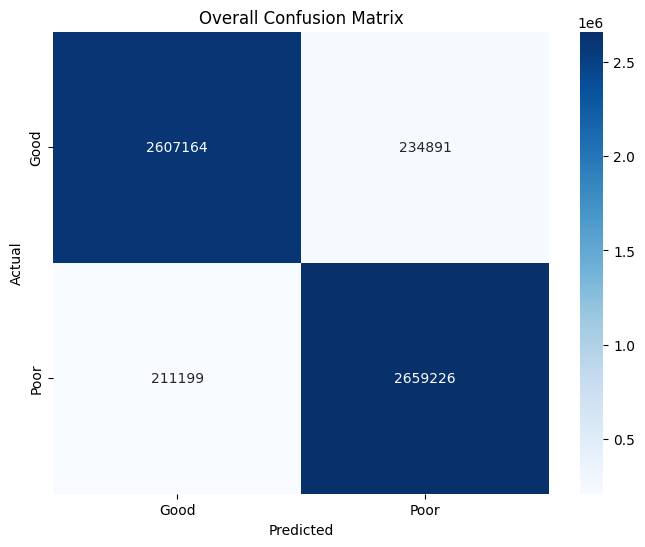


Overall Metrics:
Accuracy: 0.9219
Precision: 0.9188
Recall: 0.9264
F1 Score: 0.9226


In [23]:
# After getting metrics
print("\nCalculating detailed accuracy metrics...")
metrics = evaluate_model_per_location_and_hour(
    model, test_loader, device, location_indices
)

# Extract metrics
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]
preds_flat = metrics["preds_flat"]
labels_flat = metrics["labels_flat"]

# Plot overall confusion matrix
print("\nOverall Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(overall_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Good', 'Poor'],
            yticklabels=['Good', 'Poor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Overall Confusion Matrix')
plt.savefig('overall_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1 Score: {overall_metrics['f1']:.4f}")


Generating example predictions...


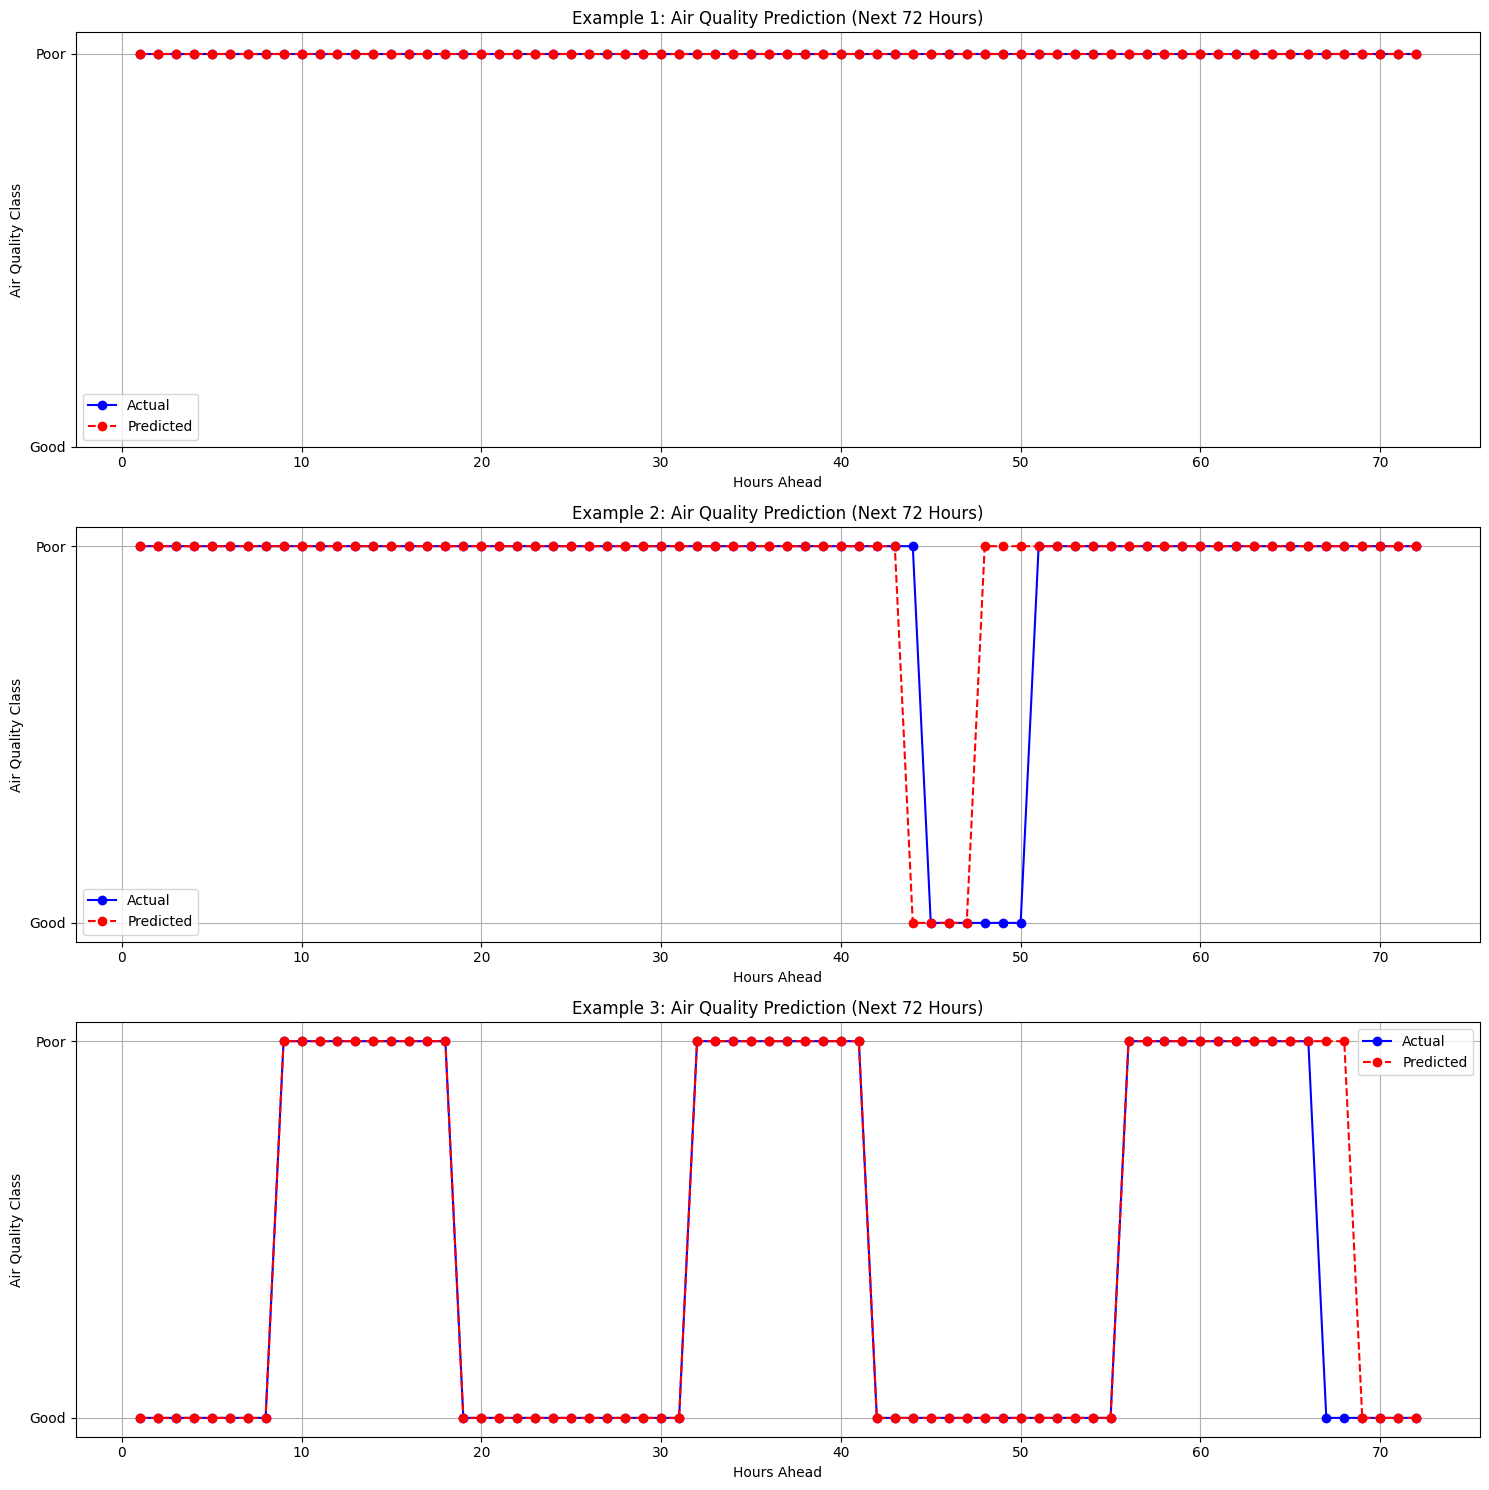


Testing complete. Results saved.


In [24]:
print("\nGenerating example predictions...")
plot_example_predictions(model, X_test, y_test, num_examples=3)

print("\nTesting complete. Results saved.")